In [74]:
import torch
from torchvision import models
import numpy as np
import cv2
#这段代码使用了I-FGM算法生成对抗样本。首先定义优化目标。目标是什么？有两种情况。如果是Non-target的情况，那么假设正确
#标签是[1,0,0],那么我们就要minimum第一个标签的概率。如果是target的情况，那么我们就要maximum目标标签的概率。
#可以直接用第一个标签的值为优化目标，但是这样做的话，性能会比较差。这里我们用信息论的交叉熵来定义优化目标。这种方式的
#优点是我们将优化目标改为了模型所拥有的信息。以信息来度量是更合理的方式。这里我们用pytorch的交叉熵函数来定义优化目标。
#我们不需要训练一个新的模型，只需要用原来的模型来生成梯度，并利用梯度更新图片。
#对梯度取符号是FGSM。对梯度取反是I-FGM。

#技巧：通过conda安装包时，最好不要使用vpn，否则会出现各种问题。


In [75]:
#现在第一个问题是：如何提取logits层的参数？

In [76]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()
    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original,{}'.format(original_label))
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial,{}'.format(adversarial_label))
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [77]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [78]:
#在这里我需要一个原始图像集
#图像加载以及预处理
image_path="cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

#load the class label
with open('./data/imagenet_classes.txt', 'r') as f:
    labels_name_array = [line.strip() for line in f.readlines()]



#preprocess method,follow the value of imagenet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)#HWC->CHW

img=np.expand_dims(img, axis=0)#add batch dim
img=torch.from_numpy(img).float()
img.requires_grad = True#图像数据梯度可以获取
img.to(device)
#img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)


#使用预测模式 固定droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

original_label=np.argmax(model(img).data.cpu().numpy())
print("original_label={}".format(original_label))

torch.Size([1, 3, 224, 224])
original_label=388


In [79]:
# #设置为不保存梯度值 自然也无法修改
# for param in model.parameters():
#     param.requires_grad = False
#这两段不保存除了img之外的梯度值，因为我们不需要修改模型，只需要修改图片

optimizer = torch.optim.SGD([img], lr=0.1)
optimizer2= torch.optim.Adam([img], lr=0.1)
loss_func = torch.nn.CrossEntropyLoss()

epochs=200
loss_gap=10 #在cross entropy中，loss_gap越大,正确标签被选择到的概率越小。这个数值越大
second_stage_loss_gap=0.2
#优化第一阶段的时间就

for epoch in range(epochs):
    # 梯度清零
    optimizer.zero_grad()

    # forward + backward
    output = model(img)
    #在这里output就是logits层的值
    original_label_array=np.zeros(output.shape)
    original_label_array[0][original_label]=1
    
    loss = -1*loss_func(output,torch.from_numpy(original_label_array).to(device))
    label=np.argmax(output.data.cpu().numpy())
    
    print("epoch={} loss={} label={}".format(epoch,-1*loss,label))
    if loss*-1 >loss_gap:
        print("first stage attack success,now turn to the second stage")
        second_stage_target=label
        break
    #如果定向攻击成功
    # if label == target:
    #     break  
    if epoch==epochs-1:
        second_stage_target=label
    loss.backward()
    optimizer.step()

epoch=0 loss=0.07570672035217285 label=388
epoch=1 loss=0.08100875467061996 label=388
epoch=2 loss=0.08708767592906952 label=388
epoch=3 loss=0.09406911581754684 label=388
epoch=4 loss=0.10220635682344437 label=388
epoch=5 loss=0.11133846640586853 label=388
epoch=6 loss=0.12172706425189972 label=388
epoch=7 loss=0.1341591775417328 label=388
epoch=8 loss=0.14861726760864258 label=388
epoch=9 loss=0.16599273681640625 label=388
epoch=10 loss=0.1881294697523117 label=388
epoch=11 loss=0.21639101207256317 label=388
epoch=12 loss=0.25544989109039307 label=388
epoch=13 loss=0.3129732310771942 label=388
epoch=14 loss=0.4002963602542877 label=388
epoch=15 loss=0.5303866863250732 label=388
epoch=16 loss=0.7575942277908325 label=388
epoch=17 loss=1.1606183052062988 label=388
epoch=18 loss=1.9026869535446167 label=388
epoch=19 loss=3.0673584938049316 label=266
epoch=20 loss=4.595256805419922 label=266
epoch=21 loss=6.157177925109863 label=266
epoch=22 loss=7.735202312469482 label=266
epoch=23 loss

In [80]:
#second stage attack,try to optimize the target label

In [81]:
for epoch in range(epochs):
       # 梯度清零
    optimizer2.zero_grad()

    # forward + backward
    output = model(img)
    #在这里output就是logits层的值
    target_label_array=np.zeros(output.shape)
    target_label_array[0][second_stage_target]=1
    
    #in this stage,we need to minimize the error between target label and output
    loss = loss_func(output,torch.from_numpy(target_label_array).to(device))
    label=np.argmax(output.data.cpu().numpy())
    
    print("epoch={} loss={} label={}".format(epoch,loss,label))
    if loss<second_stage_loss_gap:
        print("second stage attack success")
        second_stage_target=label
        break
    #如果定向攻击成功
    # if label == target:
    #     break  
    loss.backward()
    optimizer2.step()

epoch=0 loss=1.3889644145965576 label=266
epoch=1 loss=0.3988688588142395 label=266
epoch=2 loss=0.23292498290538788 label=266
epoch=3 loss=0.03120771050453186 label=266
second stage attack success


(3, 224, 224)


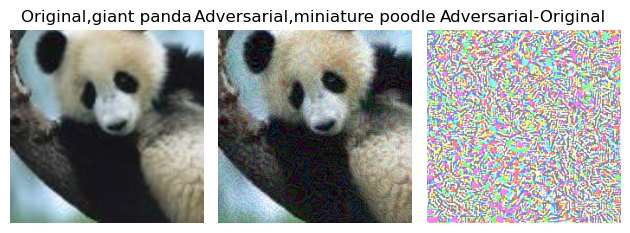

In [82]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
#adv = adv[..., ::-1]  # RGB to BGR
adv = np.clip(adv, 0, 255).astype(np.uint8)
adv_label=np.argmax(model(img).data.cpu().numpy())

show_images_diff(orig,labels_name_array[original_label],adv,labels_name_array[adv_label])